# List of Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from collections import Counter

from os import listdir

In [2]:
def read_CSV_in_years(YEARS = ('2019', '2020', '2021', '2022', '2023')):
    '''
    Parameters
    -----------
    YEARS        : Years to include/open.

    Parameters
    -----------
    Opens all the MRT train csv files within the provided years.
    Call cleanCSV() to open, clean, and return a dataframe.

    Return   
    ------------
    pd.Dataframe : All the cleaned CSVs compiled into a single dataframe.
    '''
    compiled_df = []
    FILES = listdir('MTR Parsed')

    # OPEN AND STORE ALL THE TARGET CSV FILES
    for fileName in FILES:
        if fileName[-4:] == '.csv' and fileName[:4] in YEARS:
            compiled_df.append(clean_CSV(fileName))
    
    return pd.concat(compiled_df)

In [3]:
def clean_CSV(fileName, min_traffic_threshold = 0):
    '''
    Parameters
    -----------
    fileName               : String name of the .csv file.
    min_traffic_threshold  : Stations records with daily traffic below the threshold will be dropped.

    Parameters
    -----------
    Open the csv file and drop all records of stations with little/no activity for the entire day.

    Return   
    ------------
    pd.Dataframe : The cleaned csv data.
    '''
    df = pd.read_csv('MTR Parsed/' + fileName)
    # REMOVE INDEX COL
    df = df.drop(df.columns[0], axis=1)

    # CHECK THE TRAFFIC ACTIVITY OF PER STATION EVERYDAY 
    '''
    activity_check = df[['Day', 'Station_No', 'Net_Traffic']]
    activity_check = activity_check.groupby(['Day', 'Station_No']).sum()
    
    # KEEP ONLY THE STATION RECORDS THAT HAD ACTIVITY FOR THAT DAY
    records_to_keep = activity_check[activity_check.values > min_traffic_threshold]
    df = df.set_index(['Day', 'Station_No']).join(records_to_keep, lsuffix='' , rsuffix='_ActivityCheck')
    df = df.dropna(axis=0)
    df = df.rename(columns={df.columns[-1]:'Station_Total_Day_Traffic'})
    '''
    
    df['Date'] = pd.to_datetime(df['Date'])
    # df = df.reset_index()
    
    return df

# Title and Authors

# Introduction of Problem

Link of Dataset

In [4]:
def convertToString(num : int):
    if(num < 10):
        return '0' + str(num)
    else:
        return str(num)

def joinNumsToString(df : pd.DataFrame, cols : list[str], separator = '_'):
    colName = cols[0] + separator + cols[1]
    df[colName] = df[cols[0]].apply(lambda x: convertToString(x)) +  separator + df[cols[1]].apply(lambda x: convertToString(x))

## Opening the data

The data was previously converted from xlsx separated tables format into a csv. 

The conversion appears to be succesful but there are caveats:
<li>February 2019 xlsx was corrupted and not converted</li>
<li>There are days with entirely 0 entry & exit records</li>
<li>The records contain all days present only within said month. 31st and February leap days are excluded</li>

In [5]:
df = read_CSV_in_years()

df['Net_Traffic'] = df['Entry'] - df['Exit']
df = df.reset_index().drop(columns='index')
df.tail()

,Date,Time,Station_Name,Station_No,Entry,Exit,Net_Traffic,Year,Month,Day,Hour,Weekday,Is_Holiday
531084,2023-12-31,02:00 - 02:59,Guadalupe,8,0,0.0,0.0,2023,12,31,2,6,True
531085,2023-12-31,02:00 - 02:59,Buendia,9,0,0.0,0.0,2023,12,31,2,6,True
531086,2023-12-31,02:00 - 02:59,Ayala Ave,10,0,0.0,0.0,2023,12,31,2,6,True
531087,2023-12-31,02:00 - 02:59,Magallanes,11,0,0.0,0.0,2023,12,31,2,6,True
531088,2023-12-31,02:00 - 02:59,Taft,12,0,0.0,0.0,2023,12,31,2,6,True


In [6]:
print(f'Entries: {df.shape}')

Entries: (531089, 13)


In [7]:
df.isnull().any()

Date            False
Time            False
Station_Name    False
Station_No      False
Entry           False
Exit            False
Net_Traffic     False
Year            False
Month           False
Day             False
Hour            False
Weekday         False
Is_Holiday      False
dtype: bool

## Feature extraction
Additional features can be extracted to ease timeseries understanding. These could be making hours relative to months, days, etc.

In [8]:
joinNumsToString(df, ['Year', 'Month'])
joinNumsToString(df, ['Month', 'Hour'])
joinNumsToString(df, ['Weekday', 'Hour'])
joinNumsToString(df, ['Day', 'Hour'])

### Optimize formats
Safe to lower the int64 and float64 formats. They are within int16 range and people are countable.

This reduces memory usage from original 67.3 MB to ~40MB

In [9]:
convertCols = df.select_dtypes(['int', 'float']).columns
df[convertCols].max()

Station_No       12.0
Entry          7445.0
Exit           7333.0
Net_Traffic    7170.0
Year           2023.0
Month            12.0
Day              31.0
Hour             23.0
Weekday           6.0
dtype: float64

In [10]:
for col in convertCols:
    if df[col].max() <= 127:
        df[col] = df[col].astype('int8')
    elif df[col].max() <= 32767:
        df[col] = df[col].astype('int16')
    else:
        print(f"{col} data out of range")
        assert False
        
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531089 entries, 0 to 531088
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          531089 non-null  datetime64[ns]
 1   Time          531089 non-null  object        
 2   Station_Name  531089 non-null  object        
 3   Station_No    531089 non-null  int8          
 4   Entry         531089 non-null  int16         
 5   Exit          531089 non-null  int16         
 6   Net_Traffic   531089 non-null  int16         
 7   Year          531089 non-null  int16         
 8   Month         531089 non-null  int8          
 9   Day           531089 non-null  int8          
 10  Hour          531089 non-null  int8          
 11  Weekday       531089 non-null  int8          
 12  Is_Holiday    531089 non-null  bool          
 13  Year_Month    531089 non-null  object        
 14  Month_Hour    531089 non-null  object        
 15  Weekday_Hour  531

## Incomplete records
The data provided by MTR is shown to be incomplete. 

<li> It records more entries than exits, rather than balancing/negating each other at 0 difference.</li>
<li> Extreme positive/negative outliers are also present. </li>
<li> In addition there are days with totally 0 records due to completely no entrance and exit for the day.</li>

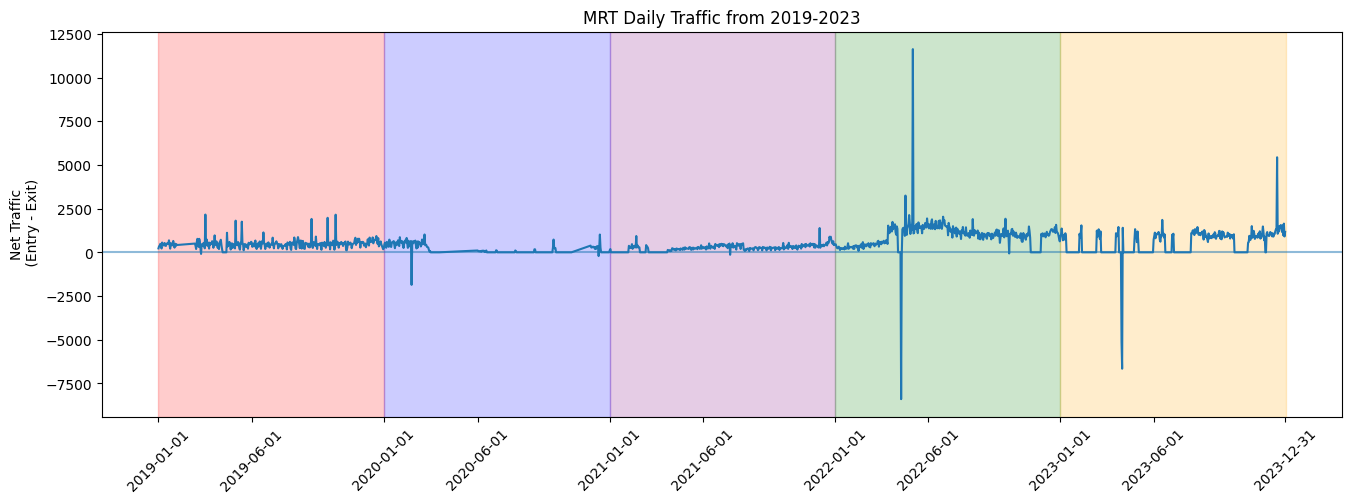

In [11]:
fig = plt.subplots(figsize=(16, 5))
plt.plot(df[['Net_Traffic', 'Date']].groupby('Date').sum())
plt.title("MRT Daily Traffic from 2019-2023")
plt.ylabel("Net Traffic\n (Entry - Exit)")

ticks = ['2019-01-01',  '2019-06-01', 
         '2020-01-01',  '2020-06-01',
         '2021-01-01',  '2021-06-01',
         '2022-01-01',  '2022-06-01',
         '2023-01-01',  '2023-06-01', '2023-12-31']
plt.xticks(ticks, rotation=45)
plt.axvspan('2019-01-01', '2020-01-01', color='red', alpha=0.2)
plt.axvspan('2020-01-01', '2021-01-01', color='blue', alpha=0.2)
plt.axvspan('2021-01-01', '2022-01-01', color='purple', alpha=0.2)
plt.axvspan('2022-01-01', '2023-01-01', color='green', alpha=0.2)
plt.axvspan('2023-01-01', '2024-01-01', color='orange', alpha=0.2)

plt.axhline(0, alpha=0.5)

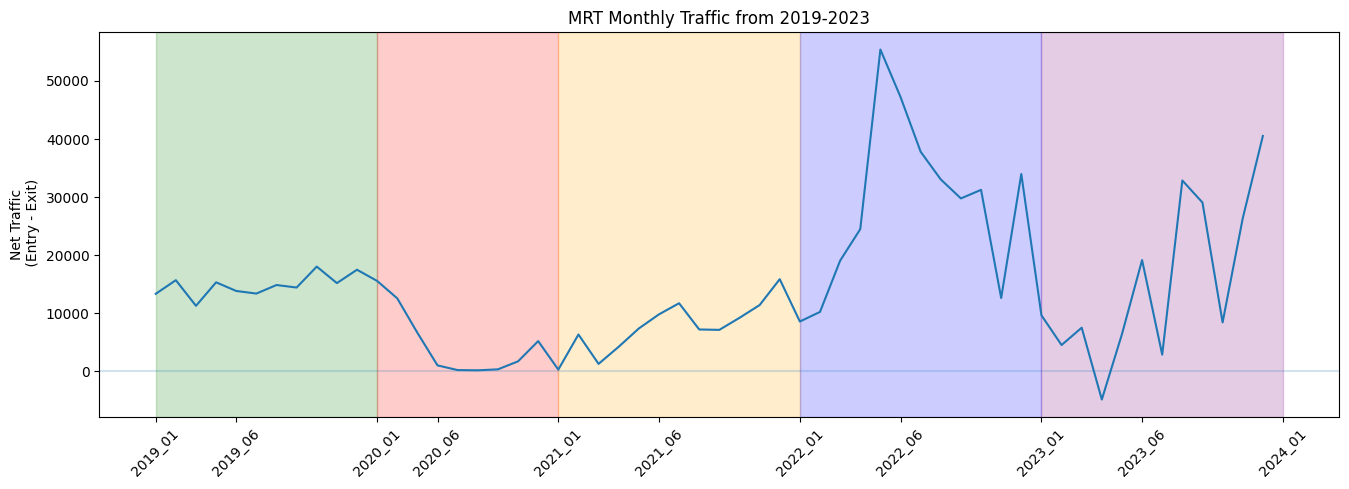

In [12]:
fig = plt.subplots(figsize=(16, 5))
plot_df = df[['Net_Traffic', 'Year_Month']].groupby('Year_Month').sum() 
plt.plot(plot_df)
plt.title("MRT Monthly Traffic from 2019-2023")
plt.ylabel("Net Traffic\n (Entry - Exit)")

ticks = []
for y in range(2019, 2024):
    for m in np.arange(1, 7, 5):
        ticks.append(str(y) + '_' + convertToString(m))
ticks.append('2024_01')

plt.xticks(ticks, rotation=45)

colors = ['green', 'red', 'orange', 'blue', 'purple']
max_range = len(ticks)//2
for i in range(0, max_range):
    plt.axvspan(ticks[2*i], ticks[i*2+2], color=colors[i % max_range], alpha=0.2)
plt.axhline(0, alpha=0.2)

# Data Cleaning and Preprocessing

## Splicing to only Post-COVID Years (2022, 2023)
To keep data relevant, we will be utilizing the post COVID records as there are still over 200,000 hourly entries.

In [13]:
composition = df.groupby('Year').count()
composition['Percentage'] = composition.iloc[:,1] / composition.iloc[:,1].sum()
composition.rename(columns={"Time":"Number of Data Points"}, inplace=True)
composition[['Number of Data Points', 'Percentage']]

,Number of Data Points,Percentage
Year,,
2019,105144,0.197978
2020,84305,0.158740
2021,113880,0.214427
2022,113880,0.214427
2023,113880,0.214427


In [14]:
df_splice = df[df['Year'] >= 2022].copy()
df_splice = df_splice.reset_index().drop(columns='index')

df_splice.shape

(227760, 17)

## Imputation
#### Get the average entry and exit according to factors such as the...
<li>Year</li>
<li>Month</li>
<li>Weekday</li>
<li>Hour</li>
<li>Station</li>

#### AVERAGING_FACTORS will control the resulting imputation. 
More specific factors will reduce its effect since some records (e.g. weekday specific to a month & year) will reference average only on 0 values.

In [15]:
AVERAGING_FACTORS = ['Year', 'Month', 'Station_Name', 'Hour']

monthly_averages = df_splice[AVERAGING_FACTORS + ['Entry', 'Exit']].groupby(AVERAGING_FACTORS).mean().apply(np.floor)
monthly_averages

Entry    Exit
Year Month Station_Name Hour                
2022 1     Ayala Ave    0        0.0     0.0
                        1        0.0     0.0
                        2        0.0     0.0
                        3        0.0     0.0
                        4        2.0     0.0
...                              ...     ...
2023 12    Taft         19    3271.0  4076.0
                        20    2737.0  3242.0
                        21    2152.0  2610.0
                        22     158.0   294.0
                        23       0.0     6.0

[7488 rows x 2 columns]

#### Get the rows with 0 records and replace them with the average.

In [16]:
mask = df_splice[['Date', 'Station_Name', 'Entry', 'Exit']].groupby(['Date', 'Station_Name']).sum() == 0
empty_days = mask[np.logical_and(mask.Entry, mask.Exit)].index

empty_records = df_splice.loc[df_splice['Date'].isin(empty_days.get_level_values(0)) & df_splice['Station_Name'].isin(empty_days.get_level_values(1))]
# empty_records.shape
# empty_records.tail()

In [17]:
merged_results = pd.merge(empty_records, monthly_averages, on=AVERAGING_FACTORS)
merged_results.Entry_x = merged_results.Entry_y
merged_results.Exit_x = merged_results.Exit_y

merged_results = merged_results.drop(columns=['Entry_y', 'Exit_y'])
merged_results = merged_results.rename(columns={'Entry_x':'Entry', 'Exit_x':'Exit'})
merged_results.index = empty_records.index
merged_results

,Date,Time,Station_Name,Station_No,Entry,Exit,Net_Traffic,Year,Month,Day,Hour,Weekday,Is_Holiday,Year_Month,Month_Hour,Weekday_Hour,Day_Hour
31824,2022-04-13,03:00 - 03:59,North Ave,0,0.0,0.0,0,2022,4,13,3,2,False,2022_04,04_03,02_03,13_03
31825,2022-04-14,03:00 - 03:59,North Ave,0,0.0,0.0,0,2022,4,14,3,3,True,2022_04,04_03,03_03,14_03
31826,2022-04-15,03:00 - 03:59,North Ave,0,0.0,0.0,0,2022,4,15,3,4,True,2022_04,04_03,04_03,15_03
31827,2022-04-16,03:00 - 03:59,North Ave,0,0.0,0.0,0,2022,4,16,3,5,True,2022_04,04_03,05_03,16_03
31828,2022-04-17,03:00 - 03:59,North Ave,0,0.0,0.0,0,2022,4,17,3,6,False,2022_04,04_03,06_03,17_03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218083,2023-11-30,02:00 - 02:59,Ayala Ave,10,0.0,0.0,0,2023,11,30,2,3,True,2023_11,11_02,03_02,30_02
218084,2023-11-29,02:00 - 02:59,Magallanes,11,0.0,0.0,0,2023,11,29,2,2,False,2023_11,11_02,02_02,29_02
218085,2023-11-30,02:00 - 02:59,Magallanes,11,0.0,0.0,0,2023,11,30,2,3,True,2023_11,11_02,03_02,30_02
218086,2023-11-29,02:00 - 02:59,Taft,12,0.0,0.0,0,2023,11,29,2,2,False,2023_11,11_02,02_02,29_02


#### Store results to df

In [18]:
df_splice.iloc[empty_records.index, df_splice.columns.get_loc('Entry')] = merged_results['Entry']
df_splice.iloc[empty_records.index, df_splice.columns.get_loc('Exit')] = merged_results['Exit']
df_splice['Net_Traffic'] = df_splice.Entry - df_splice.Exit

#### Additional cleanup
The results show that the imputations were able to eliminate all the negative traffic outliers and most of the zeroes.  

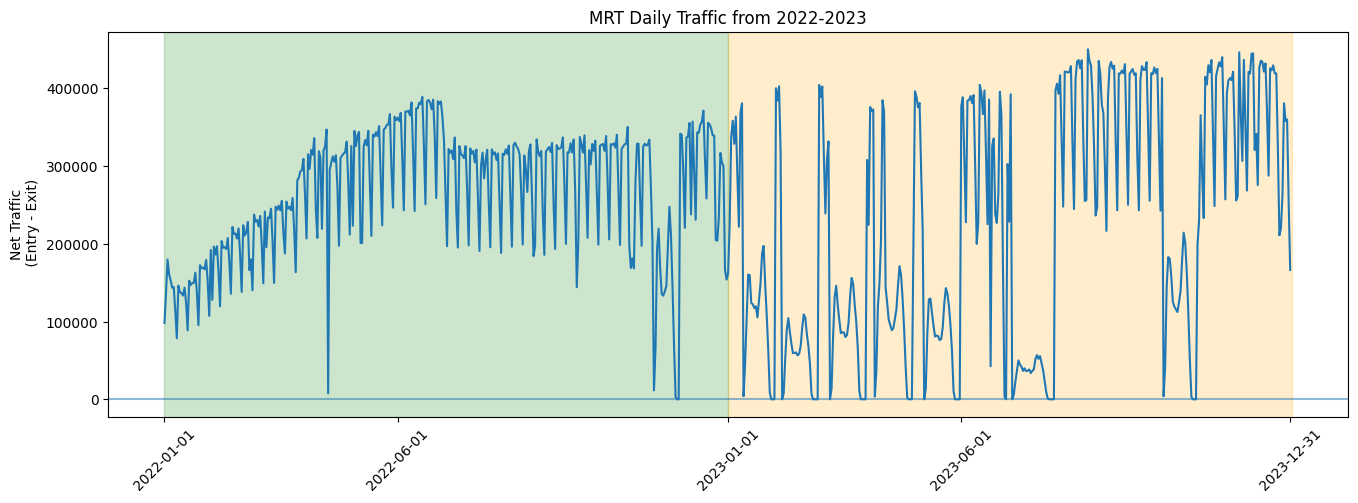

In [19]:
fig = plt.subplots(figsize=(16, 5))
plt.plot(df_splice[['Entry', 'Date']].groupby('Date').sum())
plt.title("MRT Daily Traffic from 2022-2023")
plt.ylabel("Net Traffic\n (Entry - Exit)")

ticks = ['2022-01-01',  '2022-06-01',
         '2023-01-01',  '2023-06-01', '2023-12-31']
plt.xticks(ticks, rotation=45)
plt.axvspan('2022-01-01', '2023-01-01', color='green', alpha=0.2)
plt.axvspan('2023-01-01', '2024-01-01', color='orange', alpha=0.2)

plt.axhline(0, alpha=0.5)

# Remaining anomalies
There are still anomlies present such as there being high traffic during 11pm-3am when the stations should be closed.

However it seems to originate from the **original dataset** rather than the imputations performed.

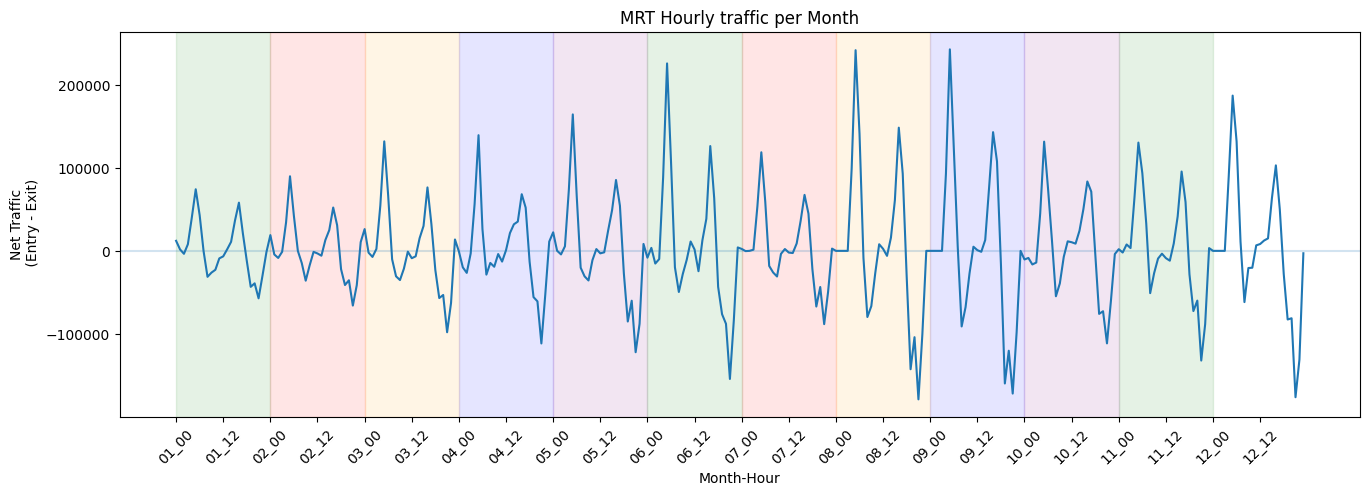

In [58]:
fig = plt.subplots(figsize=(16, 5))
plot_df = df_splice[['Net_Traffic', 'Month_Hour']].groupby('Month_Hour').sum();
plt.plot(plot_df)
plt.title("MRT Hourly traffic per Month")
plt.ylabel("Net Traffic\n (Entry - Exit)")


ticks = plot_df.index.unique()[0::12]
plt.xlabel('Month-Hour')
plt.xticks(ticks, rotation=45)


colors = ['green', 'red', 'orange', 'blue', 'purple']
max_range = len(ticks)//2 - 1
for i in range(0, max_range):
    plt.axvspan(ticks[2*i], ticks[i*2+2], color=colors[i % len(colors)], alpha=0.1)
plt.axhline(0, alpha=0.2)

In [49]:
pd.merge(
    merged_results[['Hour', 'Entry', 'Exit']].groupby('Hour').sum(),
    df[df['Year'] >= 2022][['Hour', 'Entry', 'Exit']].groupby('Hour').sum(),
    suffixes=('_Imputation','_Original'),
    on='Hour')

,Entry_Imputation,Exit_Imputation,Entry_Original,Exit_Original
Hour,,,,
0,0.0,0.0,137,2617
1,0.0,0.0,35,31
2,0.0,0.0,46,35
3,0.0,0.0,33,37
4,130041.0,30468.0,1073251,262703
5,806895.0,597632.0,6910336,5014372
6,1274777.0,1157684.0,11050008,10056928
7,1414706.0,1407265.0,12089875,12139728
8,1198569.0,1276679.0,10329638,10879958


In [56]:
# anomalies_check = df[df['Year'] >= 2022][['Hour', 'Month', 'Entry', 'Exit']].groupby(['Month', 'Hour']).sum()
# test = anomalies_check.loc[(slice(None), [23, 0, 1, 2, 3]), :]

anomalies_check = df[df['Year'] >= 2022][['Hour', 'Month', 'Entry', 'Exit']]
pd.pivot_table(test, index='Hour', columns='Month', values=['Entry', 'Exit'], aggfunc='sum')

Entry                                                            \
Month      1       2       3       4       5        6       7        8    
Hour                                                                      
0           0       0     121       2       1        5       0        0   
1           0       0      35       0       0        0       0        0   
2           0       0      44       0       1        1       0        0   
3           0       0      32       0       0        1       0        0   
4       51341   43070   64468   72659   84083   115143   66090   133223   
5      308224  284025  422853  462988  542974   766006  430659   890790   
6      488185  460983  685895  704044  826336  1202997  684327  1447521   
7      567716  518717  729791  732006  850524  1266352  736822  1586698   
8      497314  451660  625674  627328  735456  1081039  621263  1364961   
9      462338  419125  563336  555592  660445   938480  537078  1151980   
10     381950  346996  473087  481109  573108   800468  474546   963327   
11     371588  341350  467786  475301  578369   808336  484027   966704   
12     354624  318604  447034  464938  565609   808872  477183   965600   
13     341300  301324  420062  445030  539251   768941  446687   902000   
14     358955  316713  436586  467250  568667   798641  465526   926326   
15     418512  372640  513600  550390  668525   941479  543439  1089329   
16     538141  495736  689949  718142  861980  1221527  696373  1444093   
17     627793  572616  804464  840803  994424  1441660  834916  1756116   
18     575146  527012  752285  781079  915609  1347145  794786  1718902   
19     490577  427496  620565  639561  767210  1113051  649565  1407518   
20     370388  340388  482931  505364  618580   880836  496525  1068994   
21     220601  234820  328266  344813  426376   601652  325652   694838   
22      32091   31153   53324   59977   75678   105481   68552   119065   
23          0       0       0       1       4       42       2       10   

                         ...    Exit                                   \
Month       9        10  ...      3       4       5        6       7    
Hour                     ...                                            
0            0        1  ...     109      23    2274        3       2   
1            0        0  ...      27       0       0        4       0   
2            0        0  ...      32       0       0        1       2   
3            0        0  ...      36       0       0        1       0   
4       132246    84861  ...   12327   12842   15370    23338   13751   
5       904006   546695  ...  295013  322305  381821   539345  310497   
6      1469602   878713  ...  623343  654750  763709  1102658  623272   
7      1609121   969217  ...  742754  751763  874579  1292456  754455   
8      1349739   812737  ...  653017  656021  764503  1139361  645731   
9      1112262   678689  ...  588031  585353  688083   980344  563568   
10      914762   569561  ...  490051  491589  580735   814954  474378   
11      913875   575249  ...  468002  474865  575419   795711  482205   
12      920426   579577  ...  452634  463598  564511   810501  480133   
13      864976   543931  ...  422628  446985  535909   777930  447940   
14      887934   566439  ...  421770  454785  543962   777936  455691   
15     1051372   666386  ...  484579  517757  619893   884203  509339   
16     1414234   857383  ...  616135  646369  778432  1086124  631409   
17     1736211  1034794  ...  774415  799592  941382  1384658  790207   
18     1690432  1016734  ...  776243  809290  942097  1393917  817615   
19     1375362   845080  ...  678028  707636  851436  1198975  719841   
20     1033801   638910  ...  536216  559735  677541   975155  542469   
21      673708   411343  ...  418597  439550  539062   763139  413358   
22      116850    72397  ...  101648  113743  147075   200740  117497   
23           1        1  ...       1     209    3663      336       2   

          

# Exploratory Analysis

In [23]:
def plot_Entry(colName, title, xlabel, xticks):
    analysis = df_splice[[colName, 'Station_Name', 'Entry']].groupby(['Station_Name', colName]).mean()
    fig = plt.subplots(figsize=(16, 5))

    for station in analysis.index.get_level_values('Station_Name').unique():
        plt.plot(analysis.loc[station], label=station)
    
    plt.legend()
    plt.grid()
    
    plt.title(title)
    plt.ylabel('Number of Commuters Entering') 
    plt.xlabel(xlabel) 
    plt.xticks(xticks)
    
    plt.show()

    # return analysis

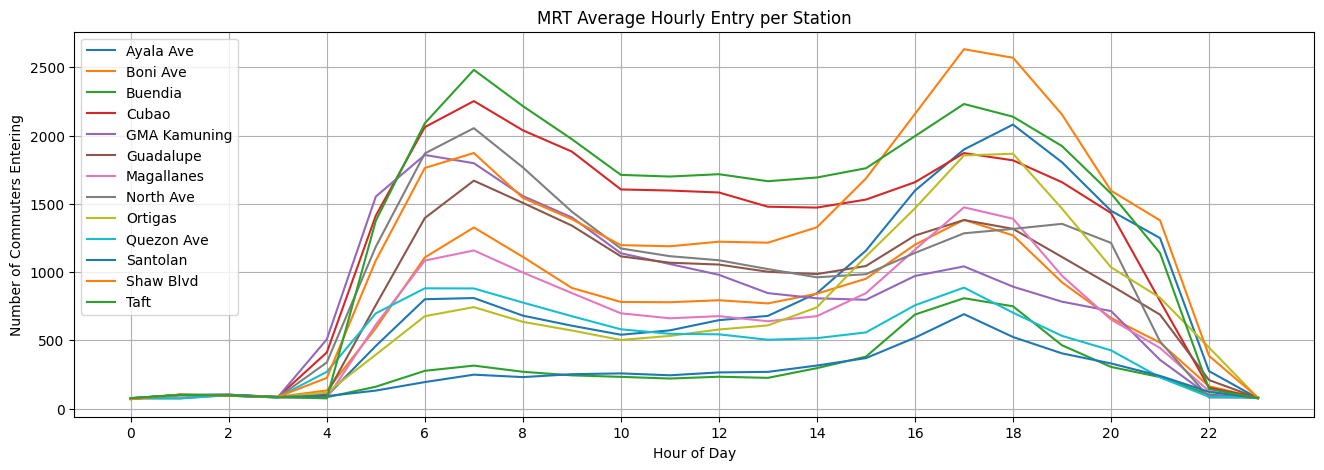

In [24]:
plot_Entry(colName='Hour', title='MRT Average Hourly Entry per Station', xlabel='Hour of Day', xticks=np.arange(0,24,2))

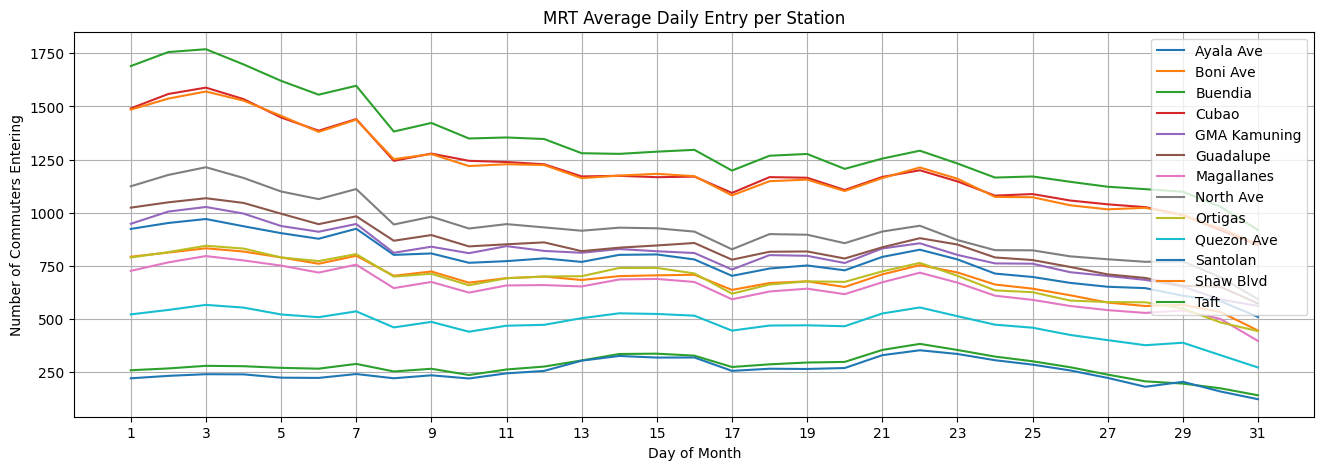

In [25]:
plot_Entry(colName='Day', title='MRT Average Daily Entry per Station', xlabel='Day of Month', xticks=np.arange(1,32,2))

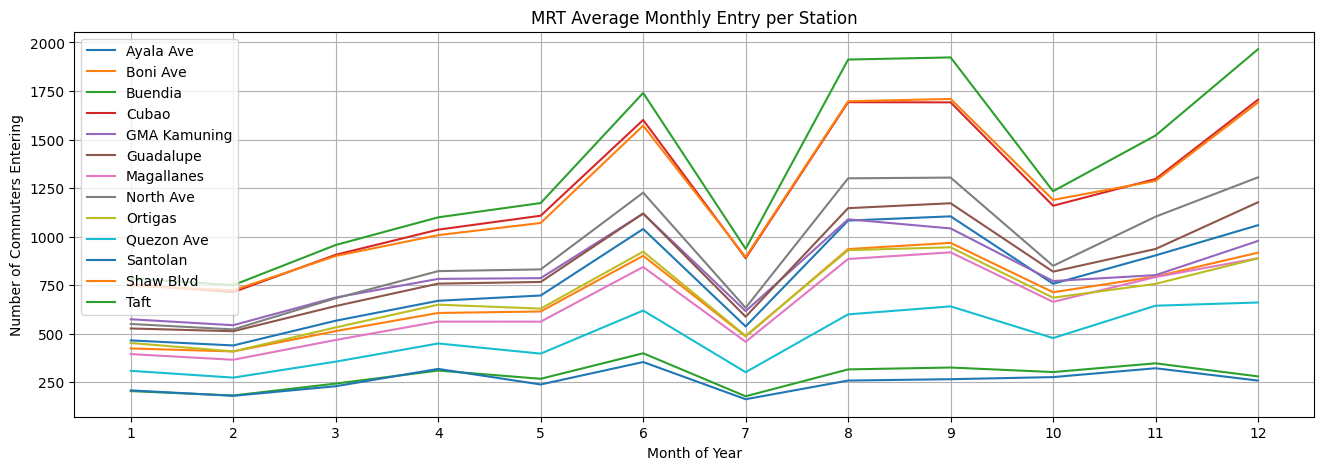

In [26]:
plot_Entry(colName='Month', title='MRT Average Monthly Entry per Station', xlabel='Month of Year', xticks=np.arange(1,13))

In [27]:
# plot_data = df_splice[['Station_Name', 'Hour', 'Entry']].groupby(['Station_Name', 'Hour']).mean()

# fig, ax = plt.subplots(figsize=(16,2))

# ax.boxplot(plot_data.loc['Taft'])
# ax.boxplot(plot_data.loc['Ayala Ave'])
# ax.boxplot(plot_data.loc['Ayala Ave'])
# fig = plt.figure(figsize =(16, 5))
# ax = fig.add_axes([0, 0, 1, 1])

# ax[0].boxplot(plot_data.loc['Taft'])
# ax[1].boxplot(plot_data.loc['Ayala Ave'])

Text(0.5, 1.0, 'Feature Correlation')

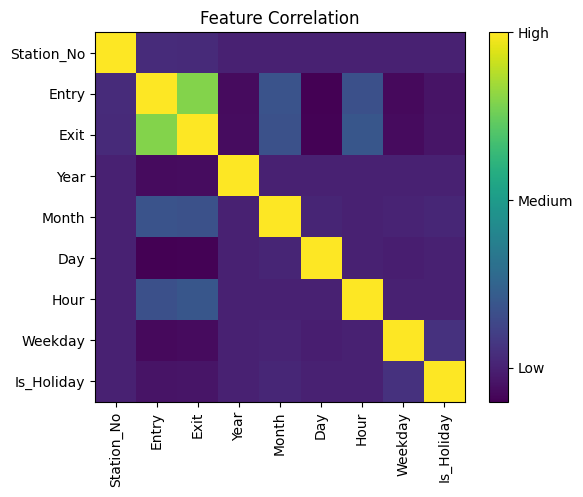

In [28]:
corr_matrix = df_splice[['Station_No', 'Entry', 'Exit', 'Year', 'Month','Day', 'Hour', 'Weekday', 'Is_Holiday']].corr()
fig = plt.subplots()

plt.imshow(corr_matrix)

# Add colorbar 
cbar = plt.colorbar(ticks=[0, 0.5, 1]) 
cbar.ax.set_yticklabels(['Low', 'Medium', 'High']) 
  
plt.xticks(range(len(corr_matrix.columns)),
           corr_matrix.columns, rotation=90) 
plt.yticks(range(len(corr_matrix.columns)), 
           corr_matrix.columns)
plt.title('Feature Correlation')


In [29]:
# def plot_Daily_Entries(df, date_ranges, title):
#     fig = plt.subplots(figsize=(16,5))
    
#     plt.plot(df['Entry'].groupby('Date').sum())
    
#     plt.title(title)
    
#     ticks = ['2019-01-01',  '2019-06-01', 
#              '2020-01-01',  '2020-06-01',
#              '2021-01-01',  '2021-06-01',
#              '2022-01-01',  '2022-06-01',
#              '2023-01-01',  '2023-06-01', '2023-12-31']
#     plt.xticks(ticks, rotation=45)

#     for i in range(len(date_ranges)):
#         plt.axvspan(date_ranges[i][0], date_ranges[i][1], color=date_ranges[i][2], alpha=0.2)  

In [30]:
# date_ranges = [
#     ('2019-01-01', '2020-01-01', 'red'),
#     ('2020-01-01', '2021-01-01', 'blue'),
#     ('2021-01-01', '2022-01-01', 'purple'),
#     ('2022-01-01', '2023-01-01', 'green'),
#     ('2023-01-01', '2024-01-01', 'orange')
# ]
# plot_Daily_Entries(df,date_ranges, 'Total Daily Entries')

In [31]:
# scaled_df = df.copy()

# min_date = '2020-03-15' #START OF LOCKDOWN
# max_date = '2022-03-28'

# lockdown_days = np.logical_and(df.index >= min_date, df.index < max_date)
# offset = (scaled_df[np.logical_not(lockdown_days)]['Entry'].mean() - scaled_df[lockdown_days]['Entry'].mean()) / 2

# scaled_df['Entry'] = scaled_df['Entry'] + (lockdown_days * offset)

# date_ranges = [
#     (min_date, max_date, 'red')
# ]
# plot_Daily_Entries(scaled_df, date_ranges, 'Total Daily Entries with Mean Offset')

In [32]:
# days = pd.to_datetime(max_date) - pd.to_datetime(scaled_df.index)
# diminishingScale = days.days / (pd.to_datetime(max_date) - pd.to_datetime(min_date)).days
# diminishingScale = 2**diminishingScale

# # plt.subplots(figsize=(16,5))
# scaled_df = df.copy()

# offset = (scaled_df[np.logical_not(lockdown_days)]['Entry'].mean() - scaled_df[lockdown_days]['Entry'].mean()) / 2

# scaled_df['Entry'] = scaled_df['Entry'] + (lockdown_days * offset * diminishingScale)

# date_ranges = [
#     (min_date, max_date, 'red')
# ]
# plot_Daily_Entries(scaled_df, date_ranges, 'Total Daily Entries with Diminishing Mean Offset')

# Feature Extraction

# Model Training

# Feature Selection & Hyperparameter Tuning

# Summary of the Best Model Configurat